# **Capitulo 5 – Time Series**

# Setup

Como hicimos en NoteBooks anteriores, vamos a definir los tamaños de fuente por defecto para que las figuras queden más bonitas:

In [1]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

Y vamos a crear la carpeta `images/time_series` (si no existe ya), y definir la función `save_fig()` que se utiliza a través de este cuaderno para guardar las figuras:

In [2]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "time_series"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Introducción #

En los NoteBooks anteriores, tratamos la previsión como un simple problema de regresión con todas nuestras características derivadas de una única entrada, el índice temporal. Podríamos crear fácilmente previsiones para cualquier momento en el futuro simplemente generando nuestras características de tendencia y estacionales deseadas.

Sin embargo, cuando añadimos las características de retardo, la naturaleza del problema cambió. Las funciones de desfase requieren que el valor objetivo desfasado se conozca en el momento de la previsión. Una función de desfase 1 desplaza la serie temporal 1 paso hacia delante, lo que significa que se puede pronosticar 1 paso en el futuro, pero no 2 pasos.

Asumimos que siempre podíamos generar desfases hasta el periodo que queríamos pronosticar (en otras palabras, cada predicción era para un solo paso adelante). La previsión en el mundo real suele exigir más que esto, por lo que en este NoteBook aprenderemos a realizar previsiones para diversas situaciones.

# Definición de la tarea de previsión

Hay que establecer dos cosas antes de diseñar un modelo de previsión:
- de qué información se dispone en el momento de realizar una previsión (características), y,
- el periodo de tiempo durante el cual se necesitan los valores pronosticados (objetivo).

El **origen de la previsión** es el momento en el que se realiza la previsión. En la práctica, se puede considerar que el origen de la previsión es el último momento para el que se dispone de datos de entrenamiento para el momento que se está pronosticando. Todo lo que llegue hasta el origen puede utilizarse para crear características.

El **horizonte de previsión** es el tiempo para el que se realiza la previsión. A menudo describimos una previsión por el número de pasos temporales de su horizonte: una previsión de "1 paso" o de "5 pasos", por ejemplo. El horizonte de previsión describe el objetivo.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/xwEgcOk.png" width=500, alt="">
<figcaption style="textalign: center; font-style: italic"><center>Un horizonte de previsión de tres pasos con un plazo de dos pasos, utilizando cuatro características de retardo. La figura representa lo que sería una única fila de datos de entrenamiento -- datos para una única predicción, en otras palabras.
</center></figcaption>
</figure>

El tiempo transcurrido entre el origen y el horizonte es el **tiempo de espera** (o a veces *latencia*) de la predicción. El plazo de una previsión se describe mediante el número de pasos desde el origen hasta el horizonte: por ejemplo, una previsión "1 paso por delante" o "3 pasos por delante". En la práctica, puede ser necesario que una previsión comience varios pasos por delante del origen debido a retrasos en la adquisición o el procesamiento de los datos.

# Preparación de los datos para la previsión

Para pronosticar series temporales con algoritmos de ML, necesitamos transformar las series en un marco de datos que podamos utilizar con esos algoritmos. (A menos, por supuesto, que sólo se utilicen características deterministas como la tendencia y la estacionalidad).

Vimos la primera mitad de este proceso cuando creamos un conjunto de características a partir de rezagos. La segunda parte consiste en preparar el objetivo. La forma de hacerlo depende de la tarea de previsión.

Cada fila de un marco de datos representa una única previsión. El índice temporal de la fila es la primera vez en el horizonte de previsión, pero ordenamos los valores de todo el horizonte en la misma fila. En el caso de las previsiones de varios pasos, esto significa que necesitamos un modelo que produzca varios resultados, uno para cada paso.

In [4]:

import numpy as np
import pandas as pd

N = 20
ts = pd.Series(
    np.arange(N),
    index=pd.period_range(start='2010', freq='A', periods=N, name='Year'),
    dtype=pd.Int8Dtype,
)

# Lag features
X = pd.DataFrame({
    'y_lag_2': ts.shift(2),
    'y_lag_3': ts.shift(3),
    'y_lag_4': ts.shift(4),
    'y_lag_5': ts.shift(5),
    'y_lag_6': ts.shift(6),    
})

# Multistep targets
y = pd.DataFrame({
    'y_step_3': ts.shift(-2),
    'y_step_2': ts.shift(-1),
    'y_step_1': ts,
})

data = pd.concat({'Targets': y, 'Features': X}, axis=1)

data.head(10)

C:\Users\jamr1\AppData\Local\Temp\ipykernel_2256\2563995091.py:7: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'Y' instead.
  index=pd.period_range(start='2010', freq='A', periods=N, name='Year'),
C:\Users\jamr1\AppData\Local\Temp\ipykernel_2256\2563995091.py:5: UserWarning: Instantiating Int8Dtype without any arguments.Pass a Int8Dtype instance to silence this warning.
  ts = pd.Series(


Targets                   Features                                
     y_step_3 y_step_2 y_step_1  y_lag_2 y_lag_3 y_lag_4 y_lag_5 y_lag_6
Year                                                                    
2010        2        1        0     <NA>    <NA>    <NA>    <NA>    <NA>
2011        3        2        1     <NA>    <NA>    <NA>    <NA>    <NA>
2012        4        3        2        0    <NA>    <NA>    <NA>    <NA>
2013        5        4        3        1       0    <NA>    <NA>    <NA>
2014        6        5        4        2       1       0    <NA>    <NA>
2015        7        6        5        3       2       1       0    <NA>
2016        8        7        6        4       3       2       1       0
2017        9        8        7        5       4       3       2       1
2018       10        9        8        6       5       4       3       2
2019       11       10        9        7       6       5       4       3

Lo anterior ilustra cómo se prepararía un conjunto de datos similar al de la figura *Definición de una previsión*: una tarea de previsión de tres pasos con un tiempo de previsión de dos pasos utilizando cinco características de retardo. La serie temporal original es `y_paso_1`. Los valores que faltan se pueden rellenar o eliminar.

# Estrategias de previsión en varios pasos

Existen varias estrategias para producir los múltiples pasos objetivo necesarios para una previsión. Esbozaremos cuatro estrategias comunes, cada una con sus puntos fuertes y débiles.

### Modelo multisalida

Utilice un modelo que produzca múltiples resultados de forma natural. Tanto la regresión lineal como las redes neuronales pueden producir múltiples resultados. Esta estrategia es simple y eficiente, pero no es posible para todos los algoritmos que desee utilizar. XGBoost no puede hacer esto, por ejemplo.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/uFsHiqr.png" width=300, alt="">
<figcaption style="textalign: center; font-style: italic"><center>
</center></figcaption>
</figure>

### Estrategia directa

Entrenar un modelo separado para cada paso en el horizonte: un modelo pronostica 1 paso por delante, otro 2 pasos por delante, y así sucesivamente. La previsión a 1 paso es un problema diferente de la previsión a 2 pasos (y así sucesivamente), por lo que puede ser útil que un modelo diferente haga previsiones para cada paso. La desventaja es que entrenar muchos modelos puede ser costoso desde el punto de vista informático.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/HkolNMV.png" width=900, alt="">
<figcaption style="textalign: center; font-style: italic"><center>
</center></figcaption>
</figure>

### Estrategia recursiva

Entrenar un único modelo de un paso y utilizar sus previsiones para actualizar las características de retardo para el siguiente paso. Con el método recursivo, volvemos a introducir la previsión de un modelo de un paso en ese mismo modelo para utilizarla como característica de retardo en el siguiente paso de previsión. Sólo es necesario entrenar un modelo, pero como los errores se propagan de una etapa a otra, las previsiones pueden ser imprecisas a largo plazo.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/sqkSFDn.png" width=300, alt="">
<figcaption style="textalign: center; font-style: italic"><center>
</center></figcaption>
</figure>

### Estrategia DirRec

Una combinación de las estrategias directa y recursiva: entrenar un modelo para cada paso y utilizar las previsiones de los pasos anteriores como *nuevas* características de retardo. Paso a paso, cada modelo recibe una entrada de retardo adicional. Dado que cada modelo siempre tiene un conjunto actualizado de características de retardo, la estrategia DirRec puede capturar la dependencia serial mejor que la Directa, pero también puede sufrir de propagación de errores como la Recursiva.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/B7KAvAO.png" width=900, alt="">
<figcaption style="textalign: center; font-style: italic"><center>
</center></figcaption>
</figure>

# Ejemplo - Tendencias de la gripe

En este ejemplo aplicaremos las estrategias MultiOutput y Direct a los datos *Flu Trends*, esta vez haciendo pronósticos verdaderos para múltiples semanas más allá del periodo de entrenamiento.

Definiremos nuestra tarea de previsión con un horizonte de 8 semanas y un plazo de 1 semana. En otras palabras, pronosticaremos ocho semanas de casos de gripe a partir de la semana siguiente.

La celda oculta configura el ejemplo y define una función de ayuda `plot_multistep`.

In [7]:

from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

simplefilter("ignore")


def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax


data_dir = Path("data")
flu_trends = pd.read_csv(data_dir / "flu-trends.csv")
flu_trends.set_index(
    pd.PeriodIndex(flu_trends.Week, freq="W"),
    inplace=True,
)
flu_trends.drop("Week", axis=1, inplace=True)

En primer lugar, prepararemos nuestra serie objetivo (visitas semanales a la consulta para la gripe) para la predicción en varios pasos. Una vez hecho esto, el entrenamiento y la predicción serán muy sencillos.

In [8]:
def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)


# Cuatro semanas de retraso
y = flu_trends.FluVisits.copy()
X = make_lags(y, lags=4).fillna(0.0)


def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)


# Previsión a ocho semanas
y = make_multistep_target(y, steps=8).dropna()

# El desplazamiento ha creado índices que no coinciden. Mantenga sólo los tiempos para
# que tenemos tanto objetivos como características.
y, X = y.align(X, join='inner', axis=0)

### Modelo multisalida

Utilizaremos la regresión lineal como estrategia MultiOutput. Una vez que tenemos nuestros datos preparados para múltiples salidas, el entrenamiento y la predicción es igual que siempre.

In [9]:
# Create splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

Recuerde que un modelo de varios pasos producirá una previsión completa para cada instancia utilizada como entrada. Hay 269 semanas en el conjunto de entrenamiento y 90 semanas en el conjunto de prueba, y ahora tenemos una previsión de 8 pasos para cada una de estas semanas.

Train RMSE: 389.12
Test RMSE: 582.33


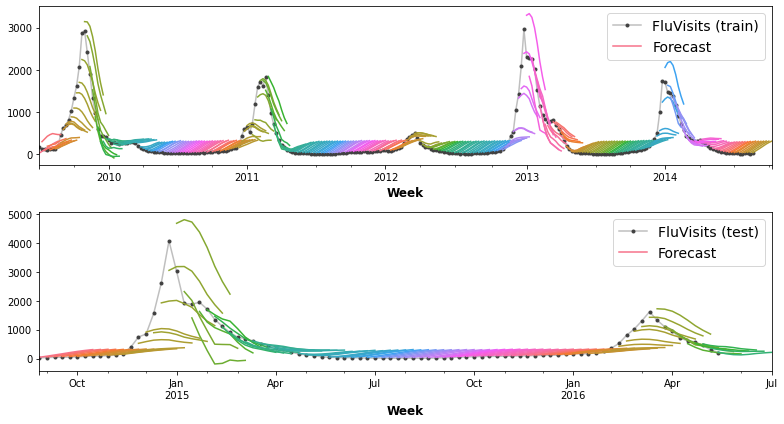

In [10]:

train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = flu_trends.FluVisits[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['FluVisits (train)', 'Forecast'])
ax2 = flu_trends.FluVisits[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['FluVisits (test)', 'Forecast'])

### Estrategia directa

XGBoost no puede producir salidas múltiples para tareas de regresión. Pero mediante la aplicación de la estrategia de reducción directa, todavía podemos utilizarlo para producir pronósticos de varios pasos. Esto es tan fácil como envolverlo con `MultiOutputRegressor` de scikit-learn.

In [11]:
from sklearn.multioutput import MultiOutputRegressor

model = MultiOutputRegressor(XGBRegressor())
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

En este caso, XGBoost está claramente sobreajustado en el conjunto de entrenamiento. Pero en el conjunto de pruebas parece que fue capaz de captar parte de la dinámica de la temporada de gripe mejor que el modelo de regresión lineal. Probablemente lo haría aún mejor con algún ajuste de hiperparámetros.

Train RMSE: 1.22
Test RMSE: 526.45


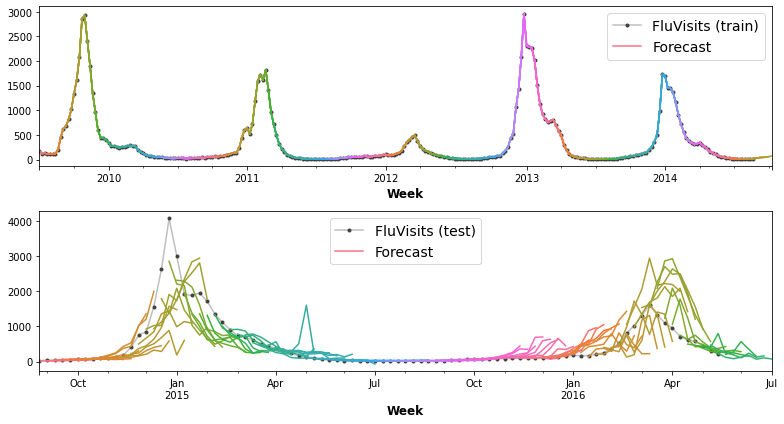

In [12]:

train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = flu_trends.FluVisits[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['FluVisits (train)', 'Forecast'])
ax2 = flu_trends.FluVisits[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['FluVisits (test)', 'Forecast'])

Para utilizar la estrategia DirRec, sólo tendría que sustituir `MultiOutputRegressor` por otro wrapper de scikit-learn, `RegressorChain`. La estrategia recursiva tendríamos que codificarla nosotros mismos.